In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")

# Getting Crypto Data
We used yahoo finance for data in this way later on we can again train our model with some newer data based on which are predictions can be more better.


In [142]:
df = yfinance.download('BTC-USD',start = '2017-01-01')

[*********************100%***********************]  1 of 1 completed


In [143]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-21 00:00:00+00:00,19053.203125,19237.384766,18770.970703,19172.468750,19172.468750,32459287866
2022-10-22 00:00:00+00:00,19172.380859,19248.068359,19132.244141,19208.189453,19208.189453,16104440957
2022-10-23 00:00:00+00:00,19207.734375,19646.652344,19124.197266,19567.007812,19567.007812,22128794335
2022-10-24 00:00:00+00:00,19567.769531,19589.125000,19206.324219,19345.572266,19345.572266,30202235805
2022-10-25 00:00:00+00:00,19336.589844,19527.873047,19261.447266,19527.873047,19527.873047,24982974464


In [4]:
df.reset_index(inplace = True)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.dtypes

Date         datetime64[ns, UTC]
Open                     float64
High                     float64
Low                      float64
Close                    float64
Adj Close                float64
Volume                     int64
dtype: object

# Visualization of Data

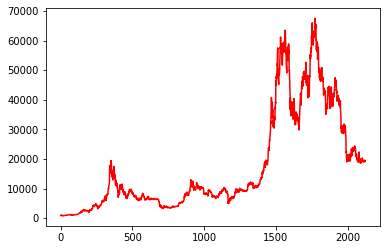

In [7]:
plt.plot(df['Open'],color = 'red')

# Lets do some EDA Before Jumping into Building Model

In [8]:
df = df[['Date','Open','Close']]

In [9]:
df.dtypes

Date     datetime64[ns, UTC]
Open                 float64
Close                float64
dtype: object

# SIMPLE MOVING AVERAGES

In [10]:
df.head()

,Date,Open,Close
0,2017-01-01 00:00:00+00:00,963.658020,998.325012
1,2017-01-02 00:00:00+00:00,998.617004,1021.750000
2,2017-01-03 00:00:00+00:00,1021.599976,1043.839966
3,2017-01-04 00:00:00+00:00,1044.400024,1154.729980
4,2017-01-05 00:00:00+00:00,1156.729980,1013.380005


In [11]:
df['Price: 10 days rolling'] = df['Close'].rolling(window = 10,min_periods = 1).mean()
df['Price: 30 days rolling'] = df['Close'].rolling(window = 30,min_periods = 1).mean()
df['Price: 50 days rolling'] = df['Close'].rolling(window = 50,min_periods = 1).mean()

<AxesSubplot:>

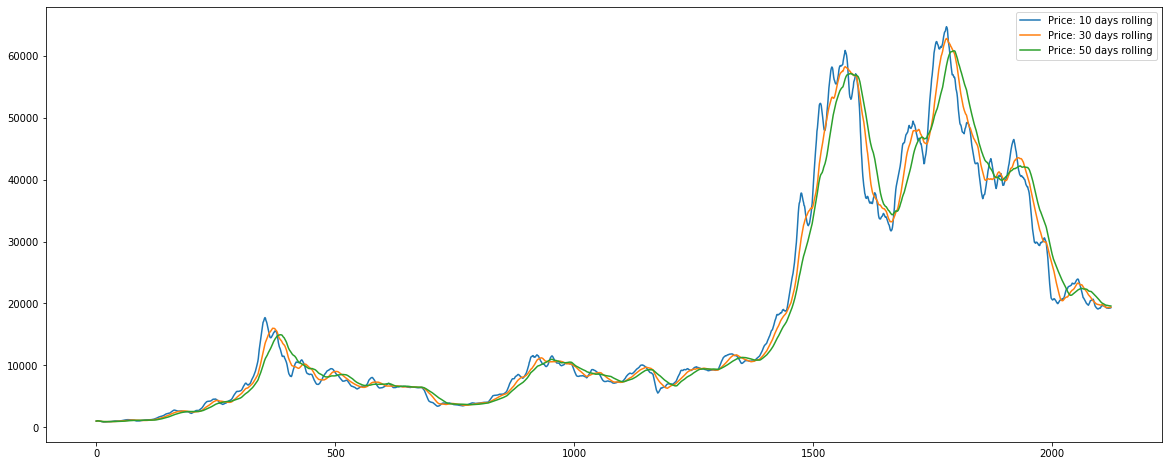

In [12]:
df[['Price: 10 days rolling','Price: 30 days rolling','Price: 50 days rolling']].plot(figsize = (20,8))

# Cummulative Moving Average

<AxesSubplot:>

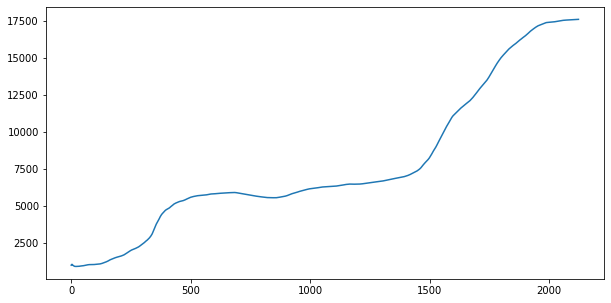

In [13]:
df['Close'].expanding().mean().plot(figsize = (10,5))

# EWMA (Exponential Weighted Moving Average)
((Price- previous Ema) * Multiplier) + Prev EMA

This will be for 10days 

Multiplier Formula = (2/(10+1)) = 0.181818 if i have a rolling window size of 10 days

In Below code alpha(α) is our smoothning factor
and span = α=2/(span+1)


In [14]:
df['EWM'] = df['Close'].ewm(span = 10).mean()


<AxesSubplot:>

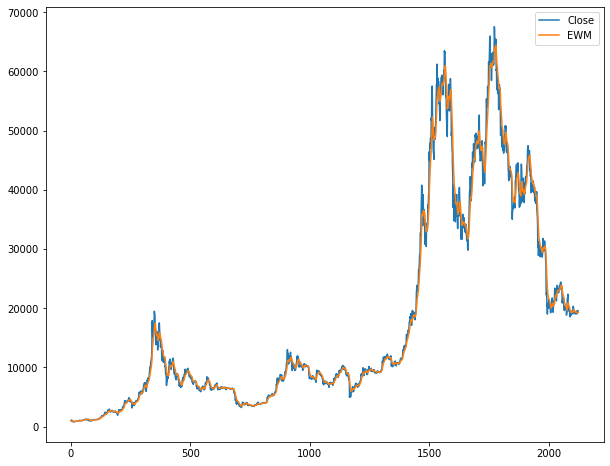

In [15]:
# EWM With Respect to 10 Days
df[['Close','EWM']].plot(figsize = (10,8))


# Lets start Preprocessing Data

In [16]:
df = df.set_index('Date')
df.head()

,Open,Close,Price: 10 days rolling,Price: 30 days rolling,Price: 50 days rolling,EWM
Date,,,,,,
2017-01-01 00:00:00+00:00,963.658020,998.325012,998.325012,998.325012,998.325012,998.325012
2017-01-02 00:00:00+00:00,998.617004,1021.750000,1010.037506,1010.037506,1010.037506,1011.208755
2017-01-03 00:00:00+00:00,1021.599976,1043.839966,1021.304993,1021.304993,1021.304993,1024.326285
2017-01-04 00:00:00+00:00,1044.400024,1154.729980,1054.661240,1054.661240,1054.661240,1067.288493
2017-01-05 00:00:00+00:00,1156.729980,1013.380005,1046.404993,1046.404993,1046.404993,1051.812832


# (ARIMA) Autoregressive integrated moving average

In [17]:
# Using Adffuller
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series)
    if result[1] <= 0.05:
        print("Rejected Null hypothesis, indicating its stationary")
    elif result[1] >= 0.05:
        print("Weak Evidence Against Null Hypothesis, indicating its non-stationary")

In [18]:
adf_test(df['Close'])

Weak Evidence Against Null Hypothesis, indicating its non-stationary


In [19]:
# Calculating Differences
df['First Difference'] =  df['Close'] - df['Close'].shift(1)
df['Second Difference'] =  df['Close'] - df['Close'].shift(2)
df['12 Difference'] =  df['Close'] - df['Close'].shift(12)

In [20]:
df.dropna(inplace = True)

In [21]:
df.head()

,Open,Close,Price: 10 days rolling,Price: 30 days rolling,Price: 50 days rolling,EWM,First Difference,Second Difference,12 Difference
Date,,,,,,,,,
2017-01-13 00:00:00+00:00,803.737000,823.984009,910.717700,936.237845,936.237845,877.072088,19.150024,46.226990,-174.341003
2017-01-14 00:00:00+00:00,825.142029,818.411987,877.085901,927.821712,927.821712,865.722922,-5.572021,13.578003,-203.338013
2017-01-15 00:00:00+00:00,818.142029,821.797974,857.927698,920.753463,920.753463,857.322523,3.385986,-2.186035,-222.041992
2017-01-16 00:00:00+00:00,821.783020,831.533997,850.860999,915.177246,915.177246,852.436668,9.736023,13.122009,-323.195984
2017-01-17 00:00:00+00:00,830.945984,907.937988,850.796295,914.751407,914.751407,862.872134,76.403992,86.140015,-105.442017


In [22]:
adf_test(df['First Difference'].dropna())

Rejected Null hypothesis, indicating its stationary


In [23]:
adf_test(df['Second Difference'].dropna())

Rejected Null hypothesis, indicating its stationary


In [24]:
adf_test(df['12 Difference'].dropna())

Rejected Null hypothesis, indicating its stationary


In [25]:
df.head()

,Open,Close,Price: 10 days rolling,Price: 30 days rolling,Price: 50 days rolling,EWM,First Difference,Second Difference,12 Difference
Date,,,,,,,,,
2017-01-13 00:00:00+00:00,803.737000,823.984009,910.717700,936.237845,936.237845,877.072088,19.150024,46.226990,-174.341003
2017-01-14 00:00:00+00:00,825.142029,818.411987,877.085901,927.821712,927.821712,865.722922,-5.572021,13.578003,-203.338013
2017-01-15 00:00:00+00:00,818.142029,821.797974,857.927698,920.753463,920.753463,857.322523,3.385986,-2.186035,-222.041992
2017-01-16 00:00:00+00:00,821.783020,831.533997,850.860999,915.177246,915.177246,852.436668,9.736023,13.122009,-323.195984
2017-01-17 00:00:00+00:00,830.945984,907.937988,850.796295,914.751407,914.751407,862.872134,76.403992,86.140015,-105.442017


In [26]:
new_df = df[['Close','EWM','First Difference','Second Difference','12 Difference']]

<AxesSubplot:xlabel='Date'>

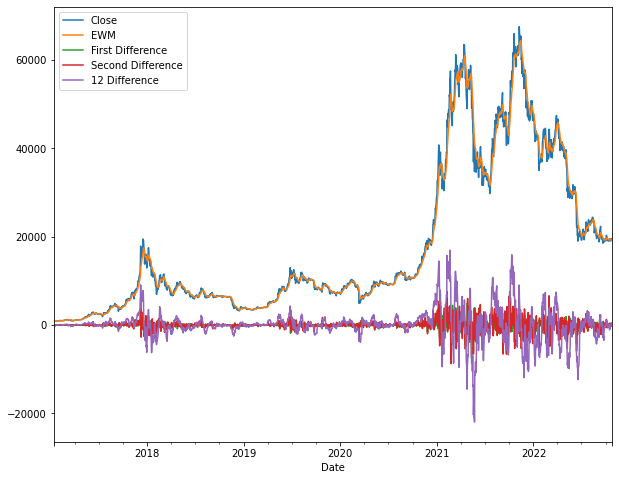

In [27]:
new_df.plot(figsize = (10,8))

# ACF And PACF

In [28]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

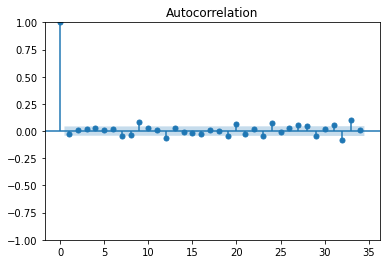

In [29]:
acf = plot_acf(new_df["First Difference"].dropna())

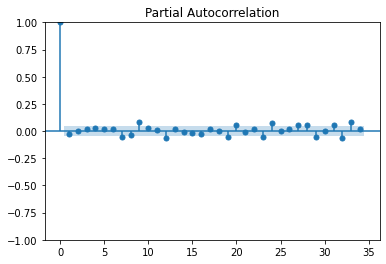

In [30]:
pacf = plot_pacf(new_df["First Difference"].dropna())

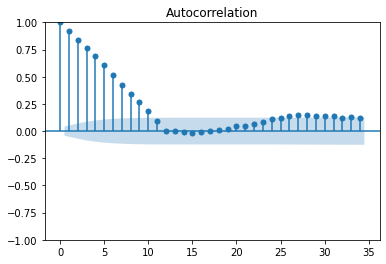

In [31]:
# Q = 4
acf = plot_acf(new_df['12 Difference'].dropna())

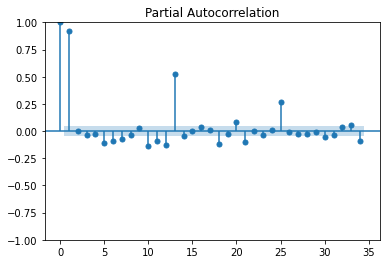

In [32]:
#P = 2
pacf = plot_pacf(new_df["12 Difference"].dropna())

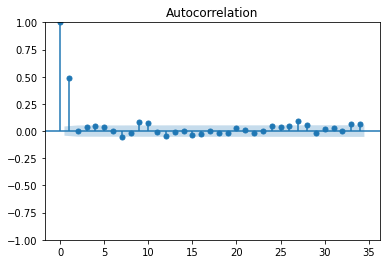

In [33]:
acf = plot_acf(new_df['Second Difference'].dropna())

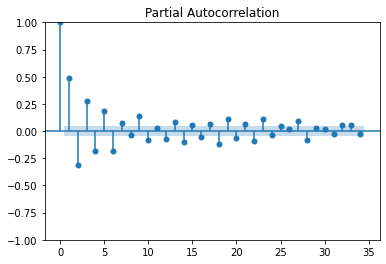

In [34]:
pacf = plot_pacf(new_df["Second Difference"].dropna())

In [35]:
new_df.head()

,Close,EWM,First Difference,Second Difference,12 Difference
Date,,,,,
2017-01-13 00:00:00+00:00,823.984009,877.072088,19.150024,46.226990,-174.341003
2017-01-14 00:00:00+00:00,818.411987,865.722922,-5.572021,13.578003,-203.338013
2017-01-15 00:00:00+00:00,821.797974,857.322523,3.385986,-2.186035,-222.041992
2017-01-16 00:00:00+00:00,831.533997,852.436668,9.736023,13.122009,-323.195984
2017-01-17 00:00:00+00:00,907.937988,862.872134,76.403992,86.140015,-105.442017


In [36]:
new_df.tail()

,Close,EWM,First Difference,Second Difference,12 Difference
Date,,,,,
2022-10-21 00:00:00+00:00,19172.468750,19240.626168,118.728516,32.933594,-273.957031
2022-10-22 00:00:00+00:00,19208.189453,19234.728583,35.720703,154.449219,66.705078
2022-10-23 00:00:00+00:00,19567.007812,19295.142988,358.818359,394.539062,515.589844
2022-10-24 00:00:00+00:00,19345.572266,19304.311948,-221.435547,137.382812,188.126953
2022-10-25 00:00:00+00:00,19484.539062,19337.080514,138.966797,-82.468750,101.634766


In [37]:
from sklearn.preprocessing import MinMaxScaler 
scaled = MinMaxScaler()
values = scaled.fit_transform(np.array(new_df['Close']).reshape(-1,1))
new_df['Close'] = values

In [38]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2022,9,19)
test_dataset_end=datetime(2022,10,19)

In [39]:
new_df.shape

(2112, 5)

In [40]:
train_data=new_df[:train_dataset_end]
test_data=new_df[train_dataset_end+timedelta(days=1):test_dataset_end]

In [41]:
print(train_data.shape)
print(test_data.shape)

(2076, 5)
(30, 5)


In [42]:
from statsmodels.tsa.arima.model import ARIMA
model_ARIMA=ARIMA(train_data['Close'],order=(1,1,1))

C:\Users\tushar nautiyal\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tushar nautiyal\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tushar nautiyal\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [43]:
model_Arima_fit=model_ARIMA.fit()
model_Arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2076
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5871.044
Date:                Tue, 25 Oct 2022   AIC                         -11736.089
Time:                        19:51:09   BIC                         -11719.175
Sample:                    01-13-2017   HQIC                        -11729.890
                         - 09-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0893      0.493     -0.181      0.856      -1.056       0.877
ma.L1          0.0630      0.495      0.127      0.899      -0.907       1.033
sigma2         0.0002   2.51e-06     81.145      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10498.32
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.06   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

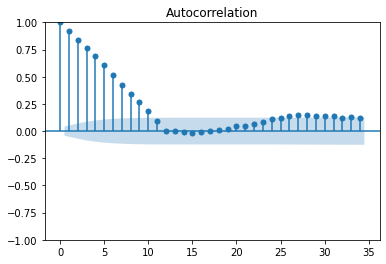

In [44]:
acf = plot_acf(new_df['12 Difference'].dropna())

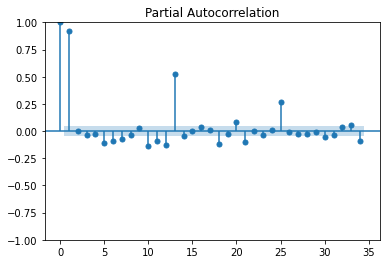

In [45]:
pacf = plot_pacf(new_df['12 Difference'].dropna())

In [46]:
# P D Q Values in Sarimax 
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA=SARIMAX(train_data['Close'],order=(6,0,11),seasonal_order=(0,1,0,12))

C:\Users\tushar nautiyal\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tushar nautiyal\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [47]:
model_SARIMA_fit=model_SARIMA.fit()
model_SARIMA_fit.summary()

C:\Users\tushar nautiyal\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                 2076
Model:             SARIMAX(6, 0, 11)x(0, 1, [], 12)   Log Likelihood                5711.686
Date:                              Tue, 25 Oct 2022   AIC                         -11387.372
Time:                                      19:51:16   BIC                         -11285.989
Sample:                                  01-13-2017   HQIC                        -11350.205
                                       - 09-19-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0797      0.018     -4.385      0.000      -0.115      -0.044
ar.L2          0.0257      0.015      1.681      0.093      -0.004       0.056
ar.L3          0.0211      0.017      1.224      0.221      -0.013       0.055
ar.L4         -0.0177      0.016     -1.090      0.276      -0.049       0.014
ar.L5          0.1124      0.017      6.703      0.000       0.080       0.145
ar.L6          0.0696      0.015      4.666      0.000       0.040       0.099
ma.L1          0.9729      0.013     72.399      0.000       0.947       0.999
ma.L2          0.9369      0.017     56.004      0.000       0.904       0.970
ma.L3          0.9416      0.018     52.097      0.000       0.906       0.977
ma.L4          0.8934      0.020     44.056      0.000       0.854       0.933
ma.L5          0.8589      0.016     53.309      0.000       0.827       0.890
ma.L6          0.9146      0.013     68.592      0.000       0.888       0.941
ma.L7          0.9197      0.014     64.677      0.000       0.892       0.948
ma.L8          0.8797      0.017     52.335      0.000       0.847       0.913
ma.L9          0.8995      0.016     55.591      0.000       0.868       0.931
ma.L10         0.8905      0.015     60.752      0.000       0.862       0.919
ma.L11         0.8365      0.010     80.721      0.000       0.816       0.857
sigma2         0.0002    3.3e-06     68.305      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   8.81   Jarque-Bera (JB):              9094.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.03   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
test_data.tail()

,Close,EWM,First Difference,Second Difference,12 Difference
Date,,,,,
2022-10-15 00:00:00+00:00,0.273403,19294.155206,-118.021484,-315.269531,-555.945312
2022-10-16 00:00:00+00:00,0.276406,19289.416759,200.458984,82.437500,-1068.750000
2022-10-17 00:00:00+00:00,0.280641,19336.933314,282.664062,483.123047,-609.958984
2022-10-18 00:00:00+00:00,0.277400,19336.475624,-216.341797,66.322266,-621.027344
2022-10-19 00:00:00+00:00,0.274480,19300.668266,-194.880859,-411.222656,-407.314453


In [49]:
test_data.head()

,Close,EWM,First Difference,Second Difference,12 Difference
Date,,,,,
2022-09-20 00:00:00+00:00,0.270754,19843.677789,-653.339844,-528.716797,-439.044922
2022-09-21 00:00:00+00:00,0.265609,19607.990989,-343.388672,-996.728516,-2833.751953
2022-09-22 00:00:00+00:00,0.278585,19572.638224,866.150391,522.761719,-2266.988281
2022-09-23 00:00:00+00:00,0.276849,19522.638306,-115.912109,750.238281,-2471.617188
2022-09-24 00:00:00+00:00,0.271446,19416.160744,-360.626953,-476.539062,-3433.437500


In [50]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2022-09-20 00:00:00+00:00
2022-10-19 00:00:00+00:00


In [51]:
pred_Sarima = model_SARIMA_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['Close']-pred_Sarima

<AxesSubplot:xlabel='Date'>

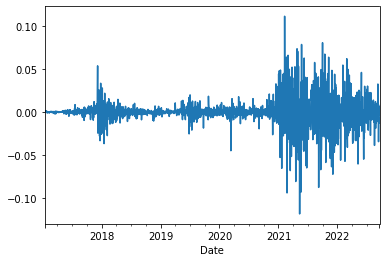

In [52]:
model_SARIMA_fit.resid.plot()

<AxesSubplot:ylabel='Density'>

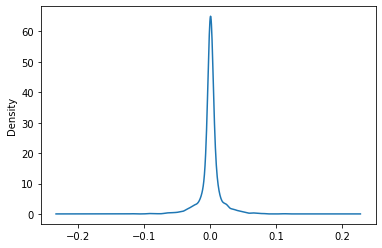

In [53]:
model_SARIMA_fit.resid.plot(kind='kde')

In [54]:
test_data['Predicted_SARIMA']=pred_Sarima

In [55]:
pred_arima = model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)

In [56]:
test_data['Predicted_ARIMA'] = pred_arima

In [57]:
pred_start_date=train_data.index[0]
pred_end_date=train_data.index[-1]
print(pred_start_date)
print(pred_end_date)
pred_arima = model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
pred_Sarima = model_SARIMA_fit.predict(start=pred_start_date,end=pred_end_date)

2017-01-13 00:00:00+00:00
2022-09-19 00:00:00+00:00


<AxesSubplot:xlabel='Date'>

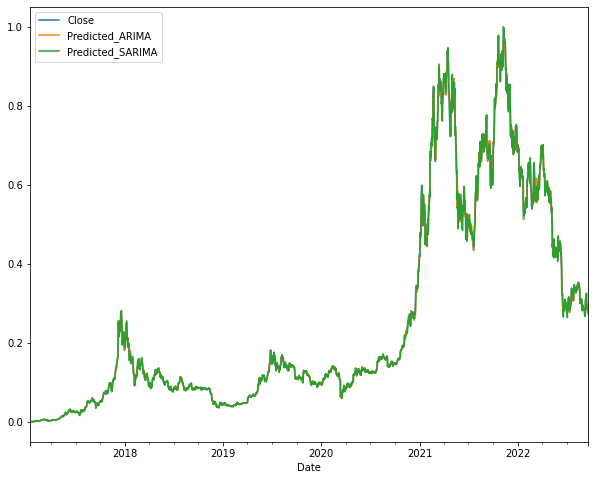

In [58]:
train_data['Predicted_ARIMA'] = pred_arima
train_data['Predicted_SARIMA']= pred_Sarima
train_data[['Close','Predicted_ARIMA','Predicted_SARIMA']].plot(figsize = (10,8))

<AxesSubplot:xlabel='Date'>

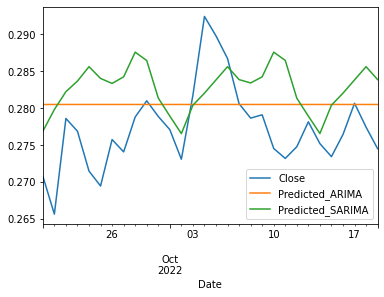

In [59]:
test_data[['Close','Predicted_ARIMA','Predicted_SARIMA']].plot()

In [60]:
# Checking Mean Squared Error and RMSE Rate For Sarima
from sklearn.metrics import mean_squared_error
Y_true = test_data['Close']
Y_pred = test_data['Predicted_SARIMA']
rmse = mean_squared_error(Y_true,Y_pred, squared = False)
mse = mean_squared_error(Y_true,Y_pred)
print(rmse,mse)

0.007845882637084614 6.155787435490583e-05


In [61]:
# Checking Error Rate For Arima
from sklearn.metrics import mean_squared_error
Y_true = test_data['Close']
Y_pred = test_data['Predicted_ARIMA']
rmse = mean_squared_error(Y_true,Y_pred, squared = False)
mse = mean_squared_error(Y_true,Y_pred)
print(rmse,mse)

0.006365353217647374 4.0517721585413775e-05


# FbProphet

In [62]:
df = yfinance.download('BTC-USD',start = '2013-01-01')

[*********************100%***********************]  1 of 1 completed


In [63]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [64]:
df.reset_index(inplace = True)

In [65]:
train_data = df[['Date','Close']]

In [66]:
train_data = train_data.rename(columns = {"Date":"ds",'Close':'y'})

In [67]:
train_data['ds'].dt.date

0       2014-09-17
1       2014-09-18
2       2014-09-19
3       2014-09-20
4       2014-09-21
           ...    
2956    2022-10-21
2957    2022-10-22
2958    2022-10-23
2959    2022-10-24
2960    2022-10-25
Name: ds, Length: 2961, dtype: object

In [68]:
train_data['ds'] = train_data['ds'].dt.date

In [69]:
# Reducing Training Data
test_data = train_data.loc[len(train_data)-30:]
train_data = train_data.loc[:len(train_data)-30]

In [70]:
print(test_data.shape,train_data.shape)

(30, 2) (2932, 2)


In [71]:
from prophet import Prophet
model = Prophet()
model.fit(train_data)

19:51:18 - cmdstanpy - INFO - Chain [1] start processing
19:51:19 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
# Making prediction for 30 days
future = model.make_future_dataframe(periods=30)

In [73]:
future.tail()

,ds
2957,2022-10-22
2958,2022-10-23
2959,2022-10-24
2960,2022-10-25
2961,2022-10-26


In [74]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2957,2022-10-22,30411.798957,24489.266604,35746.791078
2958,2022-10-23,30428.217965,24731.658244,35816.458778
2959,2022-10-24,30463.228496,24976.570896,36138.954362
2960,2022-10-25,30470.538365,24549.517535,36476.469168
2961,2022-10-26,30513.786966,25311.993544,36038.231840


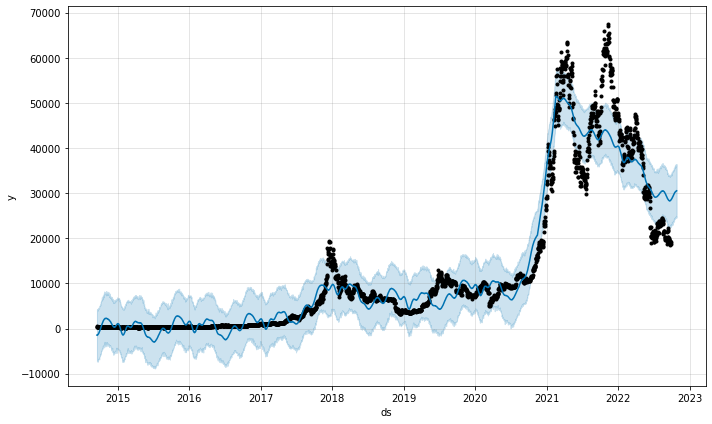

In [75]:
fig1 = model.plot(forecast)

<AxesSubplot:xlabel='Date'>

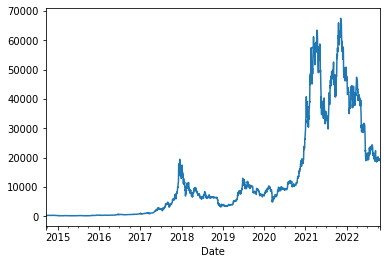

In [76]:
df.set_index('Date',inplace = True)
df['Close'].plot()

In [77]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2957,2022-10-22,28228.662385,24489.266604,35746.791078,28228.662385,28229.156258,2183.136572,2183.136572,2183.136572,3.608034,3.608034,3.608034,2179.528538,2179.528538,2179.528538,0.0,0.0,0.0,30411.798957
2958,2022-10-23,28191.597368,24731.658244,35816.458778,28191.462691,28196.428564,2236.620597,2236.620597,2236.620597,-9.364699,-9.364699,-9.364699,2245.985296,2245.985296,2245.985296,0.0,0.0,0.0,30428.217965
2959,2022-10-24,28154.532352,24976.570896,36138.954362,28150.088541,28166.382251,2308.696144,2308.696144,2308.696144,3.801889,3.801889,3.801889,2304.894255,2304.894255,2304.894255,0.0,0.0,0.0,30463.228496
2960,2022-10-25,28117.467335,24549.517535,36476.469168,28103.832760,28138.422756,2353.071030,2353.071030,2353.071030,-3.219573,-3.219573,-3.219573,2356.290603,2356.290603,2356.290603,0.0,0.0,0.0,30470.538365
2961,2022-10-26,28080.402318,25311.993544,36038.231840,28052.624346,28110.885729,2433.384648,2433.384648,2433.384648,33.096176,33.096176,33.096176,2400.288472,2400.288472,2400.288472,0.0,0.0,0.0,30513.786966


In [78]:
test_data.tail()

,ds,y
2956,2022-10-21,19172.468750
2957,2022-10-22,19208.189453
2958,2022-10-23,19567.007812
2959,2022-10-24,19345.572266
2960,2022-10-25,19484.539062


<AxesSubplot:>

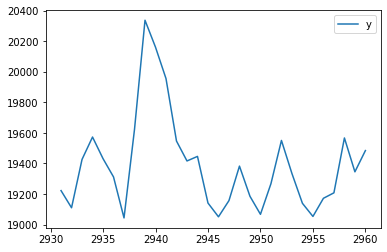

In [79]:
test_data[['ds','y']].plot()

In [80]:
graph = pd.DataFrame({'y':test_data['y'],'yhat': forecast['yhat_lower'][len(train_data)-1:-1]})

In [81]:
test_data.tail()

,ds,y
2956,2022-10-21,19172.468750
2957,2022-10-22,19208.189453
2958,2022-10-23,19567.007812
2959,2022-10-24,19345.572266
2960,2022-10-25,19484.539062


In [82]:
graph['Date'] = test_data['ds']

In [83]:
graph.head()

,y,yhat,Date
2931,19222.671875,22706.273575,2022-09-26
2932,19110.546875,23100.609559,2022-09-27
2933,19426.720703,22743.368666,2022-09-28
2934,19573.050781,22872.501296,2022-09-29
2935,19431.789062,22843.102904,2022-09-30


In [84]:
graph.set_index('Date',inplace = True)

<AxesSubplot:xlabel='Date'>

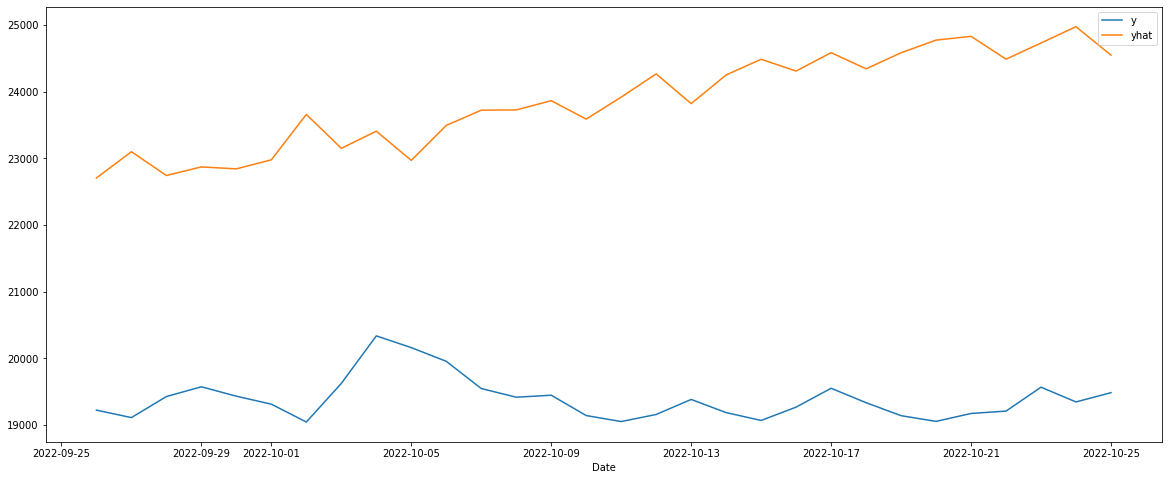

In [85]:
graph.plot(figsize = (20,8))

# Neural Prophet

In [86]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [87]:
from neuralprophet import NeuralProphet

In [88]:
model = NeuralProphet()

In [89]:
train_data.head()

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [90]:
test_data.head()

,ds,y
2931,2022-09-26,19222.671875
2932,2022-09-27,19110.546875
2933,2022-09-28,19426.720703
2934,2022-09-29,19573.050781
2935,2022-09-30,19431.789062


In [91]:
test_data.head()

,ds,y
2931,2022-09-26,19222.671875
2932,2022-09-27,19110.546875
2933,2022-09-28,19426.720703
2934,2022-09-29,19573.050781
2935,2022-09-30,19431.789062


In [92]:
test_data['ds'] = pd.to_datetime(test_data['ds'])

In [93]:
test_data.tail()

,ds,y
2956,2022-10-21,19172.468750
2957,2022-10-22,19208.189453
2958,2022-10-23,19567.007812
2959,2022-10-24,19345.572266
2960,2022-10-25,19484.539062


In [94]:
model.fit(train_data, freq='D',minimal = True)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/137 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.03E-02, min: 1.03E+00


  0%|          | 0/137 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.03E-02, min: 1.40E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.35E-02
Epoch[142/142]: 100%|████████████████████████████████████████████████████████████████| 142/142 [00:16<00:00,  8.44it/s]


In [95]:
future = model.make_future_dataframe(train_data[:-1],periods = 30)
forecast = model.predict(future)
forecast.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,residual1,yhat1,trend,season_yearly,season_weekly
25,2022-10-21,None,NaN,47752.664062,44326.289062,3407.666504,18.709747
26,2022-10-22,None,NaN,47828.894531,44349.144531,3544.648438,-64.896538
27,2022-10-23,None,NaN,48049.582031,44372.003906,3667.337158,10.240924
28,2022-10-24,None,NaN,48172.281250,44394.859375,3775.497314,1.924059
29,2022-10-25,None,NaN,48306.269531,44417.714844,3869.002197,19.550846


In [96]:
forecast = pd.merge(test_data,forecast,on = 'ds')

<AxesSubplot:>

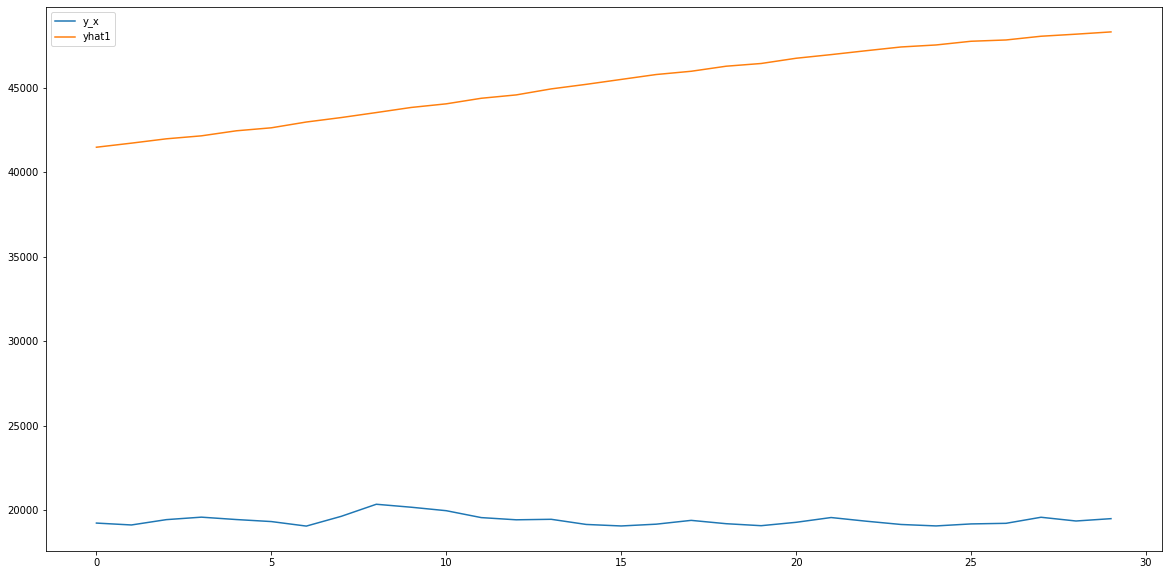

In [97]:
forecast[['y_x','yhat1']].plot(figsize = (20,10))

# LSTM

In [98]:
train_data.head()

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [99]:
test_data.head()

,ds,y
2931,2022-09-26,19222.671875
2932,2022-09-27,19110.546875
2933,2022-09-28,19426.720703
2934,2022-09-29,19573.050781
2935,2022-09-30,19431.789062


In [100]:
train_data.tail()

,ds,y
2927,2022-09-22,19413.550781
2928,2022-09-23,19297.638672
2929,2022-09-24,18937.011719
2930,2022-09-25,18802.097656
2931,2022-09-26,19222.671875


Before Training Model we need to reshape our data for LSTM So lets go ahead reshape our data.

In [101]:
X = train_data['y']

In [102]:
X.tail()

2927    19413.550781
2928    19297.638672
2929    18937.011719
2930    18802.097656
2931    19222.671875
Name: y, dtype: float64

In [103]:
from sklearn.preprocessing import MinMaxScaler 
scaled = MinMaxScaler()
values = scaled.fit_transform(np.array(X).reshape(-1,1))
X_train = values

In [104]:
X_train

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.27836865],
       [0.27636663],
       [0.28260764]])

In [105]:
X_train.shape

(2932, 1)

In [106]:
X_test = test_data['y']

In [107]:
from sklearn.preprocessing import MinMaxScaler 
scaled = MinMaxScaler()
values = scaled.fit_transform(np.array(X_test).reshape(-1,1))
X_test = values

In [108]:
X_test.shape

(30, 1)

# Data Preprocessing creating timesteps = 10
You can select timestep for as much as you like it will convert our data set in that way so basically f1..f10 and then o/p after that value

In [109]:
def create(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [110]:
# Creating The New Dataset
X_train,y_train = create(X_train,time_step = 10)
X_test,y_test = create(X_test,time_step = 10)

In [111]:
print(X_train.shape,X_test.shape) # For each 11 time step we have a output 
print(y_train.shape,y_test.shape) # For each 11 time step we have a output 

(2921, 10) (19, 10)
(2921,) (19,)


Reshaping input to be [samples, time steps, features] In this way lstm Accepts Input

In [112]:
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense,Dropout,LSTM

In [113]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [114]:
X_test.shape

(19, 10, 1)

In [115]:
# Finally Wait Is Over Lets Start Building Model
model = Sequential()
model.add(LSTM(150,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(150,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(150))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error' , metrics = ['mse', 'mae'],optimizer='adam')

In [116]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 10, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 150)           180600    
                                                                 
 dropout_1 (Dropout)         (None, 10, 150)           0         
                                                                 
 lstm_2 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [117]:
model.fit(X_train,y_train,epochs=300,batch_size=64,verbose=1)

Epoch 1/300
46/46 [==============================] - 5s 25ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0466
Epoch 2/300
46/46 [==============================] - 1s 24ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0202
Epoch 3/300
46/46 [==============================] - 1s 23ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0208
Epoch 4/300
46/46 [==============================] - 1s 23ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0178
Epoch 5/300
46/46 [==============================] - 1s 23ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0181
Epoch 6/300
46/46 [==============================] - 1s 23ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0187
Epoch 7/300
46/46 [==============================] - 1s 25ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0170
Epoch 8/300
46/46 [==============================] - 1s 29ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0175
Epoch 9/300
46/46 [==============================] - 1s 28ms/step - loss: 9.0933e-04 - mse: 9.0933e-04 - mae: 0.0158
Epoch 10/30

46/46 [==============================] - 1s 23ms/step - loss: 4.6701e-04 - mse: 4.6701e-04 - mae: 0.0129
Epoch 72/300
46/46 [==============================] - 1s 22ms/step - loss: 4.6490e-04 - mse: 4.6490e-04 - mae: 0.0129
Epoch 73/300
46/46 [==============================] - 1s 23ms/step - loss: 4.9512e-04 - mse: 4.9512e-04 - mae: 0.0133
Epoch 74/300
46/46 [==============================] - 1s 22ms/step - loss: 5.5787e-04 - mse: 5.5787e-04 - mae: 0.0141
Epoch 75/300
46/46 [==============================] - 1s 22ms/step - loss: 4.8463e-04 - mse: 4.8463e-04 - mae: 0.0133
Epoch 76/300
46/46 [==============================] - 1s 22ms/step - loss: 4.8764e-04 - mse: 4.8764e-04 - mae: 0.0132
Epoch 77/300
46/46 [==============================] - 1s 22ms/step - loss: 4.3427e-04 - mse: 4.3427e-04 - mae: 0.0123
Epoch 78/300
46/46 [==============================] - 1s 21ms/step - loss: 5.2022e-04 - mse: 5.2022e-04 - mae: 0.0135
Epoch 79/300
46/46 [==============================] - 1s 22ms/step - 

46/46 [==============================] - 1s 21ms/step - loss: 4.2744e-04 - mse: 4.2744e-04 - mae: 0.0128
Epoch 141/300
46/46 [==============================] - 1s 22ms/step - loss: 4.1159e-04 - mse: 4.1159e-04 - mae: 0.0127
Epoch 142/300
46/46 [==============================] - 1s 25ms/step - loss: 4.1085e-04 - mse: 4.1085e-04 - mae: 0.0123
Epoch 143/300
46/46 [==============================] - 1s 22ms/step - loss: 4.0221e-04 - mse: 4.0221e-04 - mae: 0.0126
Epoch 144/300
46/46 [==============================] - 1s 25ms/step - loss: 3.9569e-04 - mse: 3.9569e-04 - mae: 0.0125
Epoch 145/300
46/46 [==============================] - 1s 23ms/step - loss: 3.8804e-04 - mse: 3.8804e-04 - mae: 0.0124
Epoch 146/300
46/46 [==============================] - 1s 22ms/step - loss: 3.8741e-04 - mse: 3.8741e-04 - mae: 0.0122
Epoch 147/300
46/46 [==============================] - 1s 23ms/step - loss: 3.6845e-04 - mse: 3.6845e-04 - mae: 0.0120
Epoch 148/300
46/46 [==============================] - 1s 25ms

Epoch 209/300
46/46 [==============================] - 1s 22ms/step - loss: 3.2833e-04 - mse: 3.2833e-04 - mae: 0.0113
Epoch 210/300
46/46 [==============================] - 1s 22ms/step - loss: 3.7969e-04 - mse: 3.7969e-04 - mae: 0.0120
Epoch 211/300
46/46 [==============================] - 1s 22ms/step - loss: 3.9374e-04 - mse: 3.9374e-04 - mae: 0.0127
Epoch 212/300
46/46 [==============================] - 1s 22ms/step - loss: 3.4464e-04 - mse: 3.4464e-04 - mae: 0.0114
Epoch 213/300
46/46 [==============================] - 1s 22ms/step - loss: 3.8223e-04 - mse: 3.8223e-04 - mae: 0.0118
Epoch 214/300
46/46 [==============================] - 1s 22ms/step - loss: 3.7134e-04 - mse: 3.7134e-04 - mae: 0.0116
Epoch 215/300
46/46 [==============================] - 1s 22ms/step - loss: 3.4678e-04 - mse: 3.4678e-04 - mae: 0.0116
Epoch 216/300
46/46 [==============================] - 1s 21ms/step - loss: 3.8799e-04 - mse: 3.8799e-04 - mae: 0.0123
Epoch 217/300
46/46 [===========================

46/46 [==============================] - 1s 22ms/step - loss: 3.1723e-04 - mse: 3.1723e-04 - mae: 0.0109
Epoch 278/300
46/46 [==============================] - 1s 21ms/step - loss: 3.5744e-04 - mse: 3.5744e-04 - mae: 0.0118
Epoch 279/300
46/46 [==============================] - 1s 22ms/step - loss: 3.5579e-04 - mse: 3.5579e-04 - mae: 0.0116
Epoch 280/300
46/46 [==============================] - 1s 22ms/step - loss: 3.7318e-04 - mse: 3.7318e-04 - mae: 0.0119
Epoch 281/300
46/46 [==============================] - 1s 22ms/step - loss: 3.6969e-04 - mse: 3.6969e-04 - mae: 0.0121
Epoch 282/300
46/46 [==============================] - 1s 22ms/step - loss: 3.0667e-04 - mse: 3.0667e-04 - mae: 0.0109
Epoch 283/300
46/46 [==============================] - 1s 22ms/step - loss: 3.5693e-04 - mse: 3.5693e-04 - mae: 0.0118
Epoch 284/300
46/46 [==============================] - 1s 22ms/step - loss: 3.4602e-04 - mse: 3.4602e-04 - mae: 0.0116
Epoch 285/300
46/46 [==============================] - 1s 22ms

In [118]:
X_test

array([[[0.13812906],
        [0.05139443],
        [0.29597163],
        [0.4091657 ],
        [0.29989228],
        [0.20730313],
        [0.        ],
        [0.44825278],
        [1.        ],
        [0.86375648]],

       [[0.05139443],
        [0.29597163],
        [0.4091657 ],
        [0.29989228],
        [0.20730313],
        [0.        ],
        [0.44825278],
        [1.        ],
        [0.86375648],
        [0.7049666 ]],

       [[0.29597163],
        [0.4091657 ],
        [0.29989228],
        [0.20730313],
        [0.        ],
        [0.44825278],
        [1.        ],
        [0.86375648],
        [0.7049666 ],
        [0.3888977 ]],

       [[0.4091657 ],
        [0.29989228],
        [0.20730313],
        [0.        ],
        [0.44825278],
        [1.        ],
        [0.86375648],
        [0.7049666 ],
        [0.3888977 ],
        [0.28811826]],

       [[0.29989228],
        [0.20730313],
        [0.        ],
        [0.44825278],
        [1.        ],
  

In [119]:
y_hat = model.predict(X_test)

1/1 [==============================] - 1s 684ms/step


In [120]:
y_hat = y_hat.reshape(y_test.shape)

In [121]:
checking_df = pd.DataFrame({'yhat':y_hat,'y':y_test})

<AxesSubplot:>

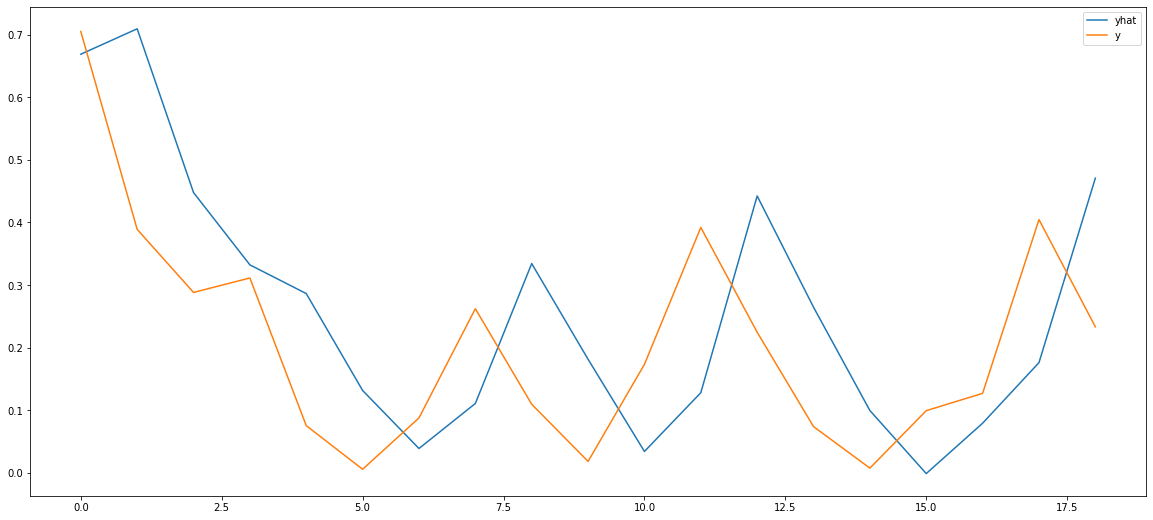

In [122]:
checking_df.plot(figsize = (20,9))

In [123]:
checking_df

,yhat,y
0,0.668656,0.704967
1,0.709264,0.388898
2,0.447670,0.288118
3,0.332168,0.311215
4,0.286316,0.075326
5,0.131503,0.005655
6,0.038818,0.087673
7,0.110768,0.262077
8,0.334238,0.109496
9,0.181342,0.018200


In [124]:
checking_df['ylag']= checking_df['yhat'].shift(-1)

# Few Days Back When i re runed the script the data that we got From LSTM was
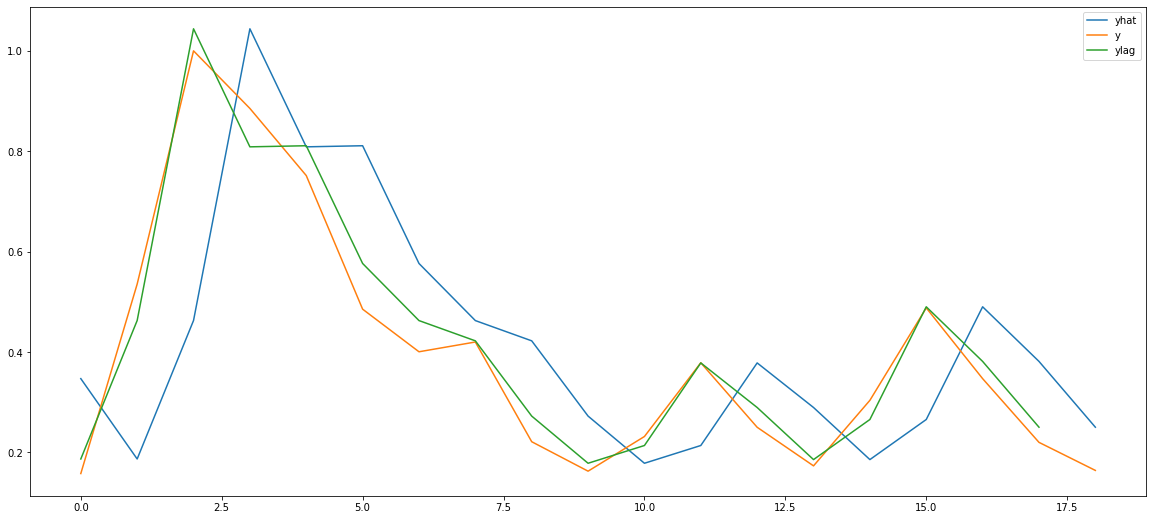

<AxesSubplot:>

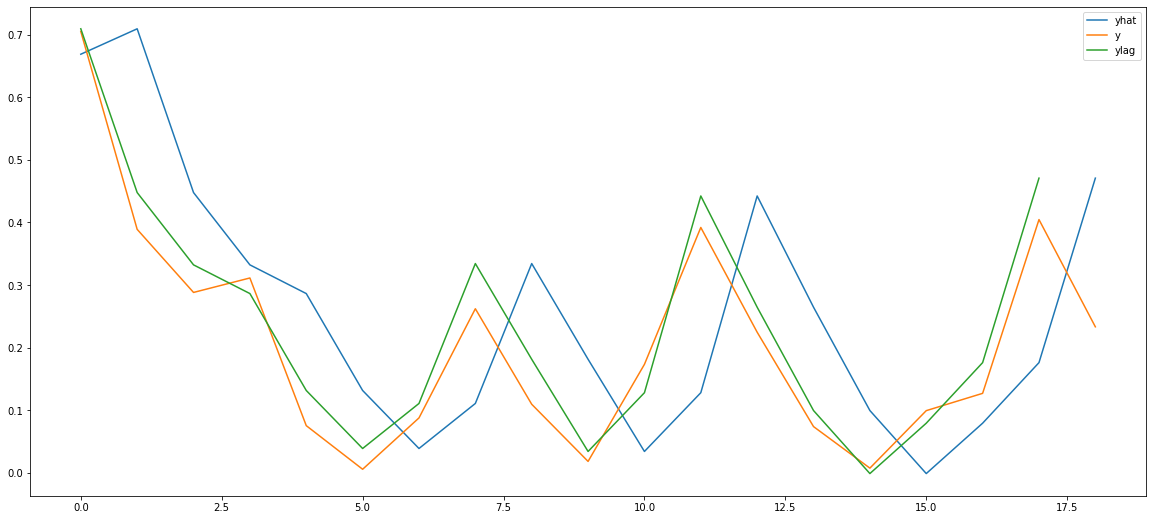

In [125]:
# Recent Data also show same characterstic by the LSTM Model.
checking_df.plot(figsize = (20,9)) #don't know why but its predicting the trajectory just lagging in terms of days so

# My final will be A Transformer- Temporal Fusion Transformer 
After this we will start building the complete end to end deployment of one model whichever works the best.

In [126]:
train_data.head()

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [127]:
X_train.shape

(2921, 10, 1)

In [128]:
from darts import TimeSeries
from darts.models.forecasting.tft_model import TFTModel

In [129]:
from darts.dataprocessing.transformers.static_covariates_transformer import StaticCovariatesTransformer
temporalFTmodel = TFTModel(input_chunk_length = 2001 ,output_chunk_length = 80,n_epochs = 50,add_relative_index = True,dropout=0.2)

In [130]:
from sklearn.preprocessing import MinMaxScaler 
scaled = MinMaxScaler()
values = scaled.fit_transform(np.array(train_data['y']).reshape(-1,1))
train = values
# Test Data
scaled = MinMaxScaler()
values = scaled.fit_transform(np.array(test_data['y']).reshape(-1,1))
test = values

In [131]:
data_training = TimeSeries.from_series(train)
data_val = TimeSeries.from_series(test)

In [132]:
data_training.head()

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[0.00414359]],

       [[0.00365546]],

       [[0.00321557]],

       [[0.00342492]],

       [[0.0032753 ]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4
  * component  (component) <U1 '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [133]:
temporalFTmodel.fit(data_training)

2022-10-25 19:57:03 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-10-25 19:57:03 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-10-25 19:57:03 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-10-25 19:57:03 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-10-25 19:57:03 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn        

Training: 0it [00:00, ?it/s]

2022-10-25 20:34:00 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


In [134]:
y_hat_new = temporalFTmodel.predict(n=30,series = data_training)

Predicting: 27it [00:00, ?it/s]

In [135]:
y_hat_new = np.array(y_hat_new.pd_series())

In [136]:
tft_combine_df = pd.DataFrame({'y_hat':y_hat_new,'y_actual': np.array(data_val.pd_series())})

In [137]:
tft_combine_df

,y_hat,y_actual
0,0.269265,0.138129
1,0.236574,0.051394
2,0.209938,0.295972
3,0.269168,0.409166
4,0.241474,0.299892
5,0.275717,0.207303
6,0.277900,0.000000
7,0.302723,0.448253
8,0.273588,1.000000
9,0.272236,0.863756


<AxesSubplot:>

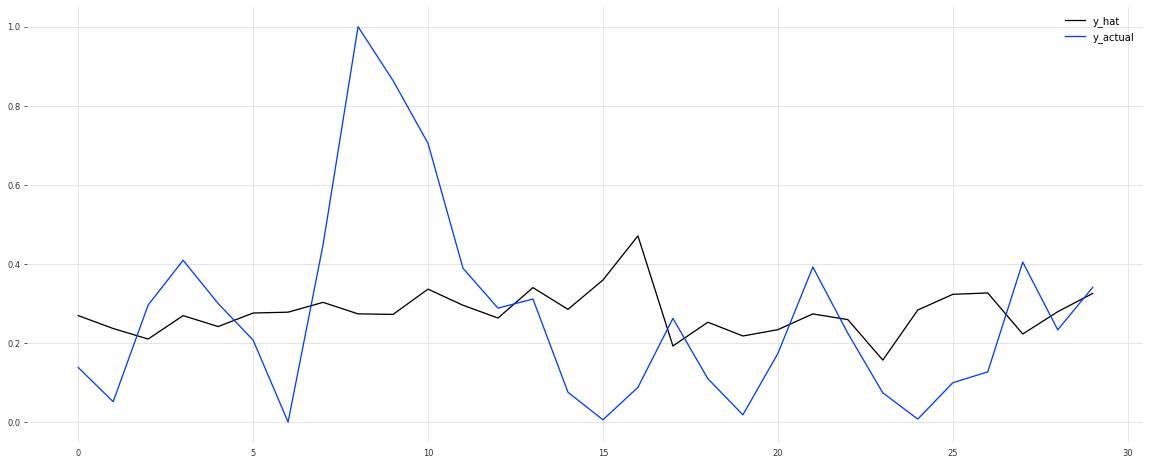

In [138]:
tft_combine_df.plot(figsize = (20,8))

# For now i'll be using LSTM To build END to END Deployed Version 
As for me lstm was very close if we reduce the lag its almost close so let's try to deploy it and use realtime bitcoin price to predict outcome in future i will be doing multivariate in which we will add sentiment and inflation factor in our data.

# Saving Model(For Testing)
I will create a build model python script that will re run automatically after 10 days or maybe month not decided yet this will make model continous and autonomously integrated.

In [139]:
# model.save('LSTM_build.h5',save_format = 'h5')

In [140]:
keras.models.load_model('LSTM_build.h5')

In [141]:
date_time_str = '18/09/19'
date_time_obj1 = datetime.strptime(date_time_str, '%d/%m/%y')
date_time_str = '23/09/29'
date_time_obj1 = datetime.strptime(date_time_str, '%d/%m/%y')
